In [3]:
!nvidia-smi

Tue Mar  2 09:16:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# EYE GAZE SHARED TASK

In [4]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
import pickle
from pickle import dump
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk import WordNetLemmatizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize 
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse = False)
Lemmatizer = WordNetLemmatizer()
std_scaler = StandardScaler()
vectorizer = TfidfVectorizer(stop_words=None)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!pip install transformers

     |████████████████████████████████| 1.9MB 5.9MB/s 
     |████████████████████████████████| 890kB 24.7MB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=e26fd8e0d0c29888ad09c97b4a78b60ad319218052a6ad1eb43c1ac5d6d7ceec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### IMPORT TRANSFORMERS

In [7]:
#@title
#from transformers import BertTokenizer, BertForTokenClassification, BertModel
#from transformers import AlbertTokenizer, AlbertModel
#from transformers import ElectraForTokenClassification, ElectraTokenizer
from transformers import RobertaForTokenClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base", add_prefix_space = True)
base_model = RobertaForTokenClassification.from_pretrained("roberta-base")

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#base_model = BertForTokenClassification.from_pretrained("bert-base-uncased")
#base_model = BertModel.from_pretrained("bert-base-uncased")

#tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
#base_model = ElectraForTokenClassification.from_pretrained("google/electra-small-discriminator")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

### DOWNLOAD DATA

In [8]:
#train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset.csv"
#test_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset.csv"
train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/training_data.csv"
test_data_file_path = "/content/drive/My Drive/CMCL Shared Task/test_data.csv"

#file_path = "/content/drive/MyDrive/datasets/EyeGazeSharedTask/trial_data.csv"

train_data = pd.read_csv(train_data_file_path)
test_data = pd.read_csv(test_data_file_path)

In [9]:
print("Train Data Shape = ", train_data.shape)
print("Test Data Shape = ", test_data.shape)
df = train_data.copy()
test_df = test_data.copy()

train_data

Train Data Shape =  (15736, 8)
Test Data Shape =  (3554, 3)


,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294
...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778


In [10]:
test_data

,sentence_id,word_id,word
0,800,0,It's
1,800,1,the
2,800,2,funniest
3,800,3,American
4,800,4,comedy
...,...,...,...
3549,990,5,pursued
3550,990,6,a
3551,990,7,career
3552,990,8,in


In [11]:
df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
sentences = list(df_data["sentences"])
MAX_LEN = df_data["max_len"][0]

test_df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")
test_sentences = list(test_df_data["sentences"])
test_MAX_LEN = test_df_data["max_len"][0]

In [12]:
test_sentences[0]

"It's the funniest American comedy since Graffiti Bridge."


























































### PREPROCESS DATA

#### REMOVE EOS TOKEN

In [13]:
#@title
# FUNCTION TO REMOVE THE <EOS> TOKEN IN THE DATASET

def remove_eos(df, train = True):
  cnt = 1
  if not train:
    cnt = 801
  endword = []
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-5]   # Remove <EOS> for the last word of each sentence.
      cnt += 1
      endword.append(1)
    else:
      endword.append(-1) 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6] 
  endword.append(1)
  df["endword"] = endword
  return df

### COUNT NO OF TOKENS FOR EACH WORD

In [14]:
#@title
# FUNCTION TO CALCULATE NO OF TOKENS CREATED BY TOKENIZER PER WORD
# ADDS THE DATA IN A NEW COLUMN

def add_token_per_words(df):
  n_tokens_per_word = []
  cdf = 0
  cf_n_token_per_word = []
  for i, word in enumerate(df.word):
    n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
    if (i > 0) and (df.loc[i-1, "sentence_id"] != df.loc[i, "sentence_id"]):
      cdf = 0
    cdf += len(tokenizer.encode(word)) - 2
    cf_n_token_per_word.append(cdf)
  df["n_tokens"] = n_tokens_per_word
  df["cf_n_tokens"] = cf_n_token_per_word
  return df

add_token_per_words(df)
add_token_per_words(test_df)
df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,n_tokens,cf_n_tokens
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,3,3
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,1,4
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,1,5
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,1,6
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,1,7
...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,1,7
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,1,8
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,1,9
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,1,10


In [15]:
test_df

,sentence_id,word_id,word,n_tokens,cf_n_tokens
0,800,0,It's,2,2
1,800,1,the,1,3
2,800,2,funniest,2,5
3,800,3,American,1,6
4,800,4,comedy,1,7
...,...,...,...,...,...
3549,990,5,pursued,1,7
3550,990,6,a,1,8
3551,990,7,career,1,9
3552,990,8,in,1,10


### NO OF CHARS FOR EACH WORD

In [16]:
#@title
# FUNCTION TO CALCULATE THE NUMBER OF CHARACTERS PER WORD
# ADDS THE DATA IN A NEW COLUMN

def char_per_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)))
  df["n_chars"] = n_chars
  return df

### NO OF CHARS OF WORD - LEMMATIZED WORD

In [17]:
#@title
# FUNCTION TO CALCULATE THE DIFFERENCE BETWEEN NUMBER OF CHARACTERS IN WORD AND LEMMATIZED WORD
# ADDS AS A NEW COLUMN

def char_per_lemmatized_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)) - len(Lemmatizer.lemmatize(word)))
  df["n_char_lemmatized"] = n_chars
  return df

### STOP WORD OR NOT

In [18]:
#@title
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
#@title
# FUNCTION TO ASSERT WHETHER A WORD IS STOPWORD  OR NOT
# ADDS THE DATA IN A NEW COLUMN

def add_stopword_check(df):
  if_stopword = []
  for word in df.word:
    if word in stop_words:
      if_stopword.append(1)
    else:
      if_stopword.append(-1)

  df["stopword"] = if_stopword
  return df

### NUMBER OR NOT

In [20]:
#@title
# FUNCTION TO DEFINE WHETHER IT IS A NUMBER OR NOT
# ADDS THE DATA AS A NEW COLUMN

def add_number_check(df):
  if_number = []
  for word in df.word:
    if_number.append(1 if word.isdigit() else -1)

  df["number"] = if_number
  return df

### TF IDF CALCULATION

In [21]:
#@title
# FUNCTION TO CALCULATE THE TFIDF OF THE TRAINING DATASET
# ADDS THE DATA IN A NEW COLUMN
# ALSO RETURNS A LIST OF THE SENTENCES

bad_words = []
punc = string.punctuation

def remove_punc(word):
  table = str.maketrans('', '', punc)
  return word.translate(table)

def calc_tfidf(df, train=True):
  start_pos = 0
  if not train:
    start_pos = 800
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  tf_idfs = []
  MAX_LEN = 0
  for i in range(start_pos, n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append(sentence)
    MAX_LEN = max(MAX_LEN, len(sentence.split()))
  if train:
    tf_idf = vectorizer.fit_transform(sentences)
  else:
    tf_idf = vectorizer.transform(sentences)

  for i, word in enumerate(df.word):
    try:
      tf_idfs.append(tf_idf.toarray()[df["sentence_id"][i]- start_pos][vectorizer.get_feature_names().index(remove_punc(word.lower()))])
    except:
      bad_words.append(word)
      if word in ["a", "A", "I"]:
        tf_idfs.append(0.8)
      else:
        tf_idfs.append(0.01)
  df["tf_idf"] = tf_idfs

  return sentences, df, bad_words, MAX_LEN

In [22]:
#@title
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

convert_dict = {"NNS":"NN",
                "PRP":"DT",
                "NN":"NN",
                "NNP":"NNP",
                "DT":"DT",
                "VB":"VB",
                "JJ":"JJ",
                "CD":"CD"}

def pos_tag_func(df, train=True):
  tags = []
  word_tag_tuple = nltk.pos_tag(df["word"])
  for word, tag in word_tag_tuple:
    if tag in convert_dict.keys():
      tags.append(convert_dict[tag]) 
    else:
      tags.append("unk")
  df["tags"] = tags
  
  if train:
    tag_transform = pd.DataFrame(enc.fit_transform(np.array(df.tags).reshape(-1, 1)))
  else:
    tag_transform = pd.DataFrame(enc.transform(np.array(df.tags).reshape(-1, 1)))
  df = pd.concat((df, tag_transform), axis = 1)
  return df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
#@title
def use_transformed_GPT(df):
  df["GPT"] = df["TRT"] - df["GPT"]
  return df

In [24]:
# FUNCTION TO PERFORM ALL PREPROCESSING STEPS
def preprocess(df, train = True):
  return calc_tfidf(pos_tag_func(add_number_check(add_stopword_check(char_per_lemmatized_word(char_per_word(add_token_per_words(remove_eos(df, train)))))), train), train)


In [25]:
sentences, df, bad_words, MAX_LEN = preprocess(train_data)
test_sentences, test_df, test_bad_words, test_MAX_LEN = preprocess(test_data, False)
df1 = df.copy()
df1

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,-1,3,3,8,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.178778
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,-1,1,4,3,1,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.060409
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,-1,1,5,6,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.178778
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,-1,1,6,7,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.310704
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,-1,1,7,9,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.275261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,-1,1,7,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.118080
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,-1,1,8,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.454322
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,-1,1,9,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.343320
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.123557


In [26]:
train_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,-1,3,3,8,0,-1,-1,NNP
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,-1,1,4,3,1,1,-1,unk
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,-1,1,5,6,0,-1,-1,JJ
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,-1,1,6,7,0,-1,-1,NN
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,-1,1,7,9,0,-1,-1,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,-1,1,7,3,0,1,-1,unk
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,-1,1,8,7,0,-1,-1,JJ
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,-1,1,9,4,0,-1,-1,NN
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,-1,1,10,2,0,1,-1,unk


In [27]:
train_data[train_data["word"]==""].count()

sentence_id          0
word_id              0
word                 0
nFix                 0
FFD                  0
GPT                  0
TRT                  0
fixProp              0
endword              0
n_tokens             0
cf_n_tokens          0
n_chars              0
n_char_lemmatized    0
stopword             0
number               0
tags                 0
dtype: int64

In [28]:
test_df

,sentence_id,word_id,word,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,800,0,It's,-1,2,2,4,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
1,800,1,the,-1,1,3,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.108989
2,800,2,funniest,-1,2,5,8,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.519424
3,800,3,American,-1,1,6,8,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.296898
4,800,4,comedy,-1,1,7,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.356212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,990,5,pursued,-1,1,7,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.010000
3550,990,6,a,-1,1,8,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.800000
3551,990,7,career,-1,1,9,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.398571
3552,990,8,in,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.137170


In [29]:
# FUNCTION TO NORMALISE ALL THE TARGET VALUES
from sklearn.preprocessing import StandardScaler

training_dataset = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/training_data.csv")
std_scaler = StandardScaler()
def standardize_target(df):
  df = use_transformed_GPT(df)
  keys = df.keys()[3:8]
  new_df = pd.DataFrame(std_scaler.fit_transform(df.iloc[:,3:8]), columns = keys)
  df.update(new_df)
  return 

standardize_target(training_dataset)
training_dataset

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,Carlucci,1.410757,1.020764,1.093189,1.382395,1.038428
1,0,1,was,-0.224947,0.241393,0.071056,-0.204384,0.361232
2,0,2,deputy,1.066398,1.841063,0.053680,1.053315,1.264160
3,0,3,defense,0.549860,1.455642,0.274461,0.837481,0.812696
4,0,4,secretary,0.291591,0.664334,0.466622,0.103379,0.812696
...,...,...,...,...,...,...,...,...
15731,799,4,and,-0.382778,0.095297,-0.282289,-0.412446,0.198203
15732,799,5,patient,0.918133,1.433756,0.341808,0.852136,1.264160
15733,799,6,wife,0.348984,0.340117,-0.191064,0.373357,0.411395
15734,799,7,of,-0.057551,0.836201,-0.998577,0.221104,0.411395


In [30]:
#standardize_target(df)

dump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))

In [31]:
df.to_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset.csv", index = False)
test_df.to_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset.csv", index = False)

In [32]:
sent_len_dict = {'sentences':sentences,
                 "max_len":MAX_LEN}
test_sent_len_dict = {'sentences':test_sentences,
                 "max_len":test_MAX_LEN}

pd.DataFrame(sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
pd.DataFrame(test_sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")

dump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))
dump(vectorizer, open("/content/drive/My Drive/CMCL Shared Task/TfIdfVectorizer.pkl", "wb"))
dump(enc, open("/content/drive/My Drive/CMCL Shared Task/OneHotEncoder.pkl", "wb"))

### FORM TARGETS

In [33]:
# FUNCTION TO FORM TARGETS AND OTHER FEATURES IN SEPARATE DATA STRUCTURES

def form_targets(sentences, df, MAX_LEN, train = True):
  start_pos = 800
  if train:
    start_pos = 0
  n = np.array(df["sentence_id"])[-1] - start_pos
  targets = []
  tags = []
  cdfs = []
  features = {"n_chars" : [],
              "stopword" : [],
              "number" : [],
              "endword":[],
              "n_char_lemmatized" : [],
              "tf_idf" : [],
              }

  for i in range(n+1):
    feature = {}
    actual_features = {}
    temp_df = df[df.sentence_id == (i+start_pos)]
    
    cdf = [0 for i in range(MAX_LEN - len(sentences[i].split()))]
    actual_cdf = list(np.array(temp_df.loc[:, "cf_n_tokens"]))
    actual_cdf += cdf

    if train:
      target = [[0] for i in range(MAX_LEN - len(sentences[i].split()))]
      actual_targets = [list(x) for x in np.array(temp_df.iloc[:, 7:8])]
      actual_targets += target

    for key in features.keys():
      feature[key] = [0 for j in range(MAX_LEN - len(sentences[i].split()))]
      actual_features[key] = list(np.array(temp_df.loc[:, key]))
      actual_features[key] += feature[key]

    tag = [[0 for j in range(6)] for k in range(MAX_LEN - len(sentences[i].split()))]
    actual_tag = [list(x) for x in np.array(temp_df.iloc[:, -8:-2])]
    actual_tag += tag

    for key in features.keys():
      features[key].append(actual_features[key]) 
    if train:
      targets.append(actual_targets) 
    tags.append(actual_tag)
    cdfs.append(actual_cdf)

  return targets, features, tags, cdfs


In [34]:
MAX_LEN = MAX_LEN + 3*10
targets, features, tags, cdfs = form_targets(sentences, df, MAX_LEN)
print("Target Shape = ", np.array(targets, dtype = "object").shape)
test_targets, test_features, test_tags, test_cdfs = form_targets(test_sentences, test_df, MAX_LEN, False)

Target Shape =  (800, 95, 1)


In [35]:
np.array(test_tags).shape

(191, 95, 6)

In [36]:
#@title
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


### FORMING CLASS OF DATA

In [37]:
# Class for the data
# Contains 4 keys -> Sentences, targets, input_ids(for BERT), attention_mask(for BERT) 

class EyeGaze_dataset(Dataset):

  def __init__(self, sentences, targets = None, cdfs = None, features = None, tags = None, tokenizer = None, train = True):
    self.sentences = sentences               # List of Sentences
    self.targets = targets                   # List of Padded Targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.cdfs = cdfs                         # Cumulative Frequency Function
    self.features = features
    self.tags = tags
    self.train = train
    
  def __len__(self):
    return len(self.sentences)               # No of Examples = 100

  def __getitem__(self, index):
    sentence = str(self.sentences[index])        # Get the review at the particular index
    if self.train:
      target = self.targets[index]                    # Get the target label at the particular index
    cdf = self.cdfs[index]
    feature = {}
    for key in features.keys():
      feature[key] = features[key][index]
    tag = tags[index]
    encoding = self.tokenizer.encode_plus(   # Encoder encoding the particular review
        sentence,
        return_attention_mask = True,
        padding = "max_length",
        max_length = MAX_LEN,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    if self.train:
      return_dict = {"target":torch.tensor(target, dtype = torch.float32),
                    "input_ids":encoding["input_ids"].flatten(),
                    "attention_mask":encoding["attention_mask"].flatten(),
                    "cdf": torch.tensor(cdf, dtype = torch.int16),
                    "tag":torch.tensor(tag, dtype = torch.float32)}
    else:
      return_dict = {"input_ids":encoding["input_ids"].flatten(),
                    "attention_mask":encoding["attention_mask"].flatten(),
                    "cdf": torch.tensor(cdf, dtype = torch.int16),
                    "tag":torch.tensor(tag, dtype = torch.float32)}
    for key in features.keys():
      return_dict[key] = torch.tensor(feature[key], dtype = torch.float32)

    return return_dict

In [38]:
# Forms the DataLoaders with test_size = 0.2
# Each DataLoader has the Class dataset as their elements
def create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, batch_size, train = True):
  data = EyeGaze_dataset(sentences, targets, cdfs, features, tags, tokenizer, train)
  
  if train:
    train, val = train_test_split(data, test_size = 0.2, shuffle = True)
    train_data_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
    val_data_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_data_loader, val_data_loader
  test_data_loader = DataLoader(data, batch_size = batch_size, shuffle = False)
  return test_data_loader
  

In [39]:
BATCH_SIZE = 4
train_data_loader, val_data_loader = create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, BATCH_SIZE)
test_data_loader = create_data_loader(test_sentences, None, test_cdfs, test_features, test_tags, tokenizer, BATCH_SIZE, False)

In [40]:
temp = next(iter(train_data_loader))
print(temp.keys())
keys = ['target', 'input_ids', 'attention_mask',  'n_chars', 'n_char_lemmatized', 'cdf', 'stopword', 'number', 'tf_idf', "tag"]
for key in keys:
  print(temp[key].size())

dict_keys(['target', 'input_ids', 'attention_mask', 'cdf', 'tag', 'n_chars', 'stopword', 'number', 'endword', 'n_char_lemmatized', 'tf_idf'])
torch.Size([4, 95, 1])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95, 6])


In [41]:
for d in test_data_loader:
  print("tags dims = ", d["tag"].size())

tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 

In [42]:
base_model.config.output_hidden_states = True

In [43]:
class LanguageHeadLayer(torch.nn.Module):
  def __init__(self):
    super(LanguageHeadLayer, self).__init__()
    self.mid = torch.nn.Linear(in_features = base_model.config.hidden_size, out_features = 128)
    self.out = torch.nn.Linear(in_features = 128, out_features = 256)
    self.act1 = torch.nn.ReLU()
    self.act2 = torch.nn.GELU()
    self.drop = torch.nn.Dropout(p = 0.3)

  def forward(self, output):
    output = self.mid(output)
    output = self.act2(output)
    output = self.drop(output)
    output = self.out(output)

    return output
    
class ExtraFeatureModel(torch.nn.Module):
  def __init__(self):
    super(ExtraFeatureModel, self).__init__()
    self.inp = torch.nn.Linear(in_features = 12, out_features = 256)
    self.transformerlayer = torch.nn.TransformerEncoderLayer(d_model = 256, nhead = 8, dim_feedforward = 256, dropout = 0.2, activation = "relu")
    self.transformer = torch.nn.TransformerEncoder(self.transformerlayer, num_layers = 2)
    self.act1 = torch.nn.GELU()
    self.act2 = torch.nn.ReLU()

  def forward(self, features):
    output = self.inp(features)
    output = self.act1(output)
    output = self.transformerlayer(output)
    output = torch.squeeze(output, dim = 0)

    return output

In [44]:
class EyeGazeClassifier(torch.nn.Module):
  def __init__(self):
    super(EyeGazeClassifier, self).__init__()
    self.base_model = base_model
    self.languageheadlayer = LanguageHeadLayer()
    self.feature_model = ExtraFeatureModel()
    self.out = torch.nn.Linear(in_features = 256, out_features = 1)

  def map_predictions(self, outputs, attention_masks, cdfs):
    for i in range(outputs.size()[0]):    
      output = outputs[i]
      attention_mask = attention_masks[i]
      cdf = cdfs[i]

      attention_mask = torch.unsqueeze(attention_mask, dim = 1)

      output = output*attention_mask

      pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)

      for j in range(0, len(cdf)-1):
        if (cdf[j+1] != 0):
          y = torch.unsqueeze(torch.mean(output[cdf[j]+1:cdf[j+1]+1], dim = 0), dim = 0)
          pred_tensor = torch.cat((pred_tensor, y), dim = 0)

      pred_pad = torch.tensor([[0 for a in range(base_model.config.hidden_size)] for k in range(MAX_LEN - pred_tensor.size()[0])], dtype = torch.float32).to(device)
      pred_tensor = torch.cat((pred_tensor, pred_pad), dim = 0)
      if i==0:
        pred_tensors = torch.unsqueeze(pred_tensor, dim = 0)
      else:
        pred_tensors = torch.cat((pred_tensors, torch.unsqueeze(pred_tensor, dim = 0)), dim = 0)

    return pred_tensors

  def forward(self, input_ids, attention_mask, cdf, extra_features):
    lang_output = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
    lang_output = self.map_predictions(lang_output["hidden_states"][-1], attention_mask, cdf)
    lang_output = self.languageheadlayer(lang_output)
    feature_output = self.feature_model(extra_features)
    output = (lang_output+feature_output)/2
    output = self.out(output)
    
    return output


In [45]:
model = EyeGazeClassifier()
model = model.to(device)

### TRAINING

In [46]:
#@title
EPOCHS = 120
from transformers import AdamW, get_linear_schedule_with_warmup

opt_params = [{"params": model.languageheadlayer.parameters()},
              {"params": model.feature_model.parameters()},
              {"params": model.out.parameters()}]

partial_optimizer = AdamW(opt_params, lr=2e-7, betas = (0.92, 0.998), correct_bias=False)
total_optimizer = AdamW(model.parameters(), lr = 3e-5, betas = (0.91, 0.998), weight_decay = 0, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

partial_scheduler = get_linear_schedule_with_warmup(
  partial_optimizer,
  num_warmup_steps=6,
  num_training_steps=total_steps
)

total_scheduler = get_linear_schedule_with_warmup(
  total_optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss(reduction = "mean").to(device)  # reduction = "mean" can be used

In [47]:
#@title
def target_initialise():
  targets = {}
  outputs = {}

  targets["r20"] = torch.tensor([], dtype = torch.float32)
  targets["r21"] = torch.tensor([], dtype = torch.float32)
  targets["r22"] = torch.tensor([], dtype = torch.float32)
  targets["r23"] = torch.tensor([], dtype = torch.float32)
  targets["r24"] = torch.tensor([], dtype = torch.float32)

  outputs["pred_r20"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r21"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r22"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r23"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r24"] = torch.tensor([], dtype = torch.float32)
  
  return targets, outputs

In [48]:
#@title
def store_targets(targets, target):
  #targets["r20"] = torch.cat([targets["r20"], target[0,:,0].detach().cpu()], dim = 0)
  #targets["r21"] = torch.cat([targets["r21"], target[0,:,0].detach().cpu()], dim = 0)
  #targets["r22"] = torch.cat([targets["r22"], target[0,:,0].detach().cpu()], dim = 0)
  #targets["r23"] = torch.cat([targets["r23"], target[0,:,0].detach().cpu()], dim = 0)
  targets["r24"] = torch.cat([targets["r24"], target[0,:,0].detach().cpu()], dim = 0)

  return targets  

def store_outputs(outputs, output):
  #outputs["pred_r20"] = torch.cat([outputs["pred_r20"], output[0,:,0].detach().cpu()], dim = 0)
  #outputs["pred_r21"] = torch.cat([outputs["pred_r21"], output[0,:,0].detach().cpu()], dim = 0)
  #outputs["pred_r22"] = torch.cat([outputs["pred_r22"], output[0,:,0].detach().cpu()], dim = 0)
  #outputs["pred_r23"] = torch.cat([outputs["pred_r23"], output[0,:,0].detach().cpu()], dim = 0)
  outputs["pred_r24"] = torch.cat([outputs["pred_r24"], output[0,:,0].detach().cpu()], dim = 0)
  
  return outputs

In [49]:
#@title
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()

  losses = []
  targets, outputs = target_initialise()  
  
  r2 = {}
  with torch.autograd.set_detect_anomaly(True):
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      if_end = torch.unsqueeze(d["endword"], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)
      tag = d["tag"]

      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end, tfidf, tag), dim = 2).to(device)

      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )

      outputs = store_outputs(outputs, output)
      
      loss = loss_fn(output, target)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
    
    #r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
    #r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
    #r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
    #r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
    r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
    
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [50]:
#@title
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  outputs = []
  r2 = {}
  targets, outputs = target_initialise()  
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      if_end = torch.unsqueeze(d["endword"], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)   
      tag = d["tag"]
      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end, tfidf, tag), dim = 2).to(device)
      
      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )
      
      outputs = store_outputs(outputs, output)
    
      loss = loss_fn(output, target)
      losses.append(loss.item())

  #r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  #r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  #r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
  #r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [51]:
def predict_model(model, data_loader, device):
  model = model.eval()
  print("Calculating Predictions on Test Set...\n")
  outputs = []
  _, outputs = target_initialise()  
  final_outputs = []

  with torch.no_grad():
    for batch, d in enumerate(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2).to(device)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2).to(device)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2).to(device)
      if_num = torch.unsqueeze(d['number'], dim = 2).to(device)
      if_end = torch.unsqueeze(d["endword"], dim = 2).to(device)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)  .to(device) 
      tag = d["tag"].to(device)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end, tfidf, tag), dim = 2).to(device)
      
      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )
      
      for i in range(output.size()[0]):
        seq_len = len(test_sentences[i+batch*BATCH_SIZE].split())
        final_outputs += output[i, : seq_len, : ].tolist()

    
  return final_outputs

In [52]:
#@title
def save(history, best):
  for key, value in history.items():
    best[key] = value[-1]

  return best

def update(history, train_loss, val_loss, train_r2, val_r2):
  
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  #history["train_nFix"].append(train_r2["nFix"])
  #history["train_FFD"].append(train_r2["FFD"])
  #history["train_GPT"].append(train_r2["GPT"])
  #history["train_TRT"].append(train_r2["TRT"])
  history["train_fixProp"].append(train_r2["fixProp"])

  #history["val_nFix"].append(val_r2["nFix"])
  #history["val_FFD"].append(val_r2["FFD"])
  #history["val_GPT"].append(val_r2["GPT"])
  #history["val_TRT"].append(val_r2["TRT"])
  history["val_fixProp"].append(val_r2["fixProp"])

  return history

In [53]:
from collections import defaultdict
from tqdm import tqdm

history = defaultdict(list)
tolerance = 0
best = {}
best = {"val_loss" : 10000}
early_stopping = EarlyStopping(patience = 8, verbose = True, delta = 0.001)

optimizer = total_optimizer
scheduler = total_scheduler

for epoch in tqdm(range(EPOCHS)):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 120)

  train_loss, train_r2 = train_epoch(model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler)
  

  print(f'Train loss {train_loss} and Train R2 {train_r2}')

  val_loss, val_r2 = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val loss {val_loss} and Val R2 {val_r2}')
  print()

  history = update(history, train_loss, val_loss, train_r2, val_r2)
  
  if val_loss < best["val_loss"]:
    best = save(history, best)
  
  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Stopped Early at at Epoch ", epoch+1)
    break
  model.load_state_dict(torch.load('checkpoint.pt'))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120
------------------------------------------------------------------------------------------------------------------------
Train loss 9.934651267528533 and Train R2 {'fixProp': 0.32785653092548805}
Val loss 5.486299455165863 and Val R2 {'fixProp': 0.7876993228256555}

Validation loss decreased (inf --> 5.486299).  Saving model ...


  1%|          | 1/120 [02:28<4:54:25, 148.45s/it]

Epoch 2/120
------------------------------------------------------------------------------------------------------------------------
Train loss 4.612021987140179 and Train R2 {'fixProp': 0.8416934435532232}
Val loss 4.132705813646316 and Val R2 {'fixProp': 0.8412742504846968}

Validation loss decreased (5.486299 --> 4.132706).  Saving model ...


  2%|▏         | 2/120 [04:57<4:52:02, 148.49s/it]

Epoch 3/120
------------------------------------------------------------------------------------------------------------------------
Train loss 3.98177684545517 and Train R2 {'fixProp': 0.8705092982107874}
Val loss 3.1790694922208784 and Val R2 {'fixProp': 0.9028596102350553}

Validation loss decreased (4.132706 --> 3.179069).  Saving model ...


  2%|▎         | 3/120 [07:26<4:49:55, 148.68s/it]

Epoch 4/120
------------------------------------------------------------------------------------------------------------------------
Train loss 3.133220458775759 and Train R2 {'fixProp': 0.9147968424266785}
Val loss 2.6518520385026934 and Val R2 {'fixProp': 0.9367720918721261}

Validation loss decreased (3.179069 --> 2.651852).  Saving model ...


  3%|▎         | 4/120 [09:55<4:47:37, 148.78s/it]

Epoch 5/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.8659855909645557 and Train R2 {'fixProp': 0.9285211501034972}
Val loss 2.5501090794801713 and Val R2 {'fixProp': 0.9363123685094984}

Validation loss decreased (2.651852 --> 2.550109).  Saving model ...


  4%|▍         | 5/120 [12:23<4:44:59, 148.69s/it]

Epoch 6/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.6783262051641943 and Train R2 {'fixProp': 0.9373115594159727}
Val loss 2.382682579755783 and Val R2 {'fixProp': 0.9480756907208423}

Validation loss decreased (2.550109 --> 2.382683).  Saving model ...


  5%|▌         | 6/120 [14:53<4:43:02, 148.97s/it]

Epoch 7/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.519432053714991 and Train R2 {'fixProp': 0.9428279301015396}
Val loss 2.33094422519207 and Val R2 {'fixProp': 0.9509627240834023}

Validation loss decreased (2.382683 --> 2.330944).  Saving model ...


  6%|▌         | 7/120 [17:23<4:41:01, 149.22s/it]

Epoch 8/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.3999820321798326 and Train R2 {'fixProp': 0.9487921334596368}
Val loss 2.3349021106958388 and Val R2 {'fixProp': 0.9487964167487756}

EarlyStopping counter: 1 out of 8


  7%|▋         | 8/120 [19:50<4:37:16, 148.54s/it]

Epoch 9/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.4055273428559305 and Train R2 {'fixProp': 0.9493256473923921}
Val loss 2.3280457615852357 and Val R2 {'fixProp': 0.9500292879411656}

Validation loss decreased (2.330944 --> 2.328046).  Saving model ...


  8%|▊         | 9/120 [22:17<4:34:16, 148.25s/it]

Epoch 10/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.3183612011373045 and Train R2 {'fixProp': 0.9515359927803988}
Val loss 2.3649269938468933 and Val R2 {'fixProp': 0.9474114370246922}

EarlyStopping counter: 1 out of 8


  8%|▊         | 10/120 [24:44<4:30:46, 147.70s/it]

Epoch 11/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.3102665178477766 and Train R2 {'fixProp': 0.9518313068896034}
Val loss 2.338694280385971 and Val R2 {'fixProp': 0.9476377398858635}

EarlyStopping counter: 2 out of 8


  9%|▉         | 11/120 [27:10<4:27:37, 147.32s/it]

Epoch 12/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.3347207598388193 and Train R2 {'fixProp': 0.9517437435021627}
Val loss 2.2952250450849534 and Val R2 {'fixProp': 0.9524461994846936}

Validation loss decreased (2.328046 --> 2.295225).  Saving model ...


 10%|█         | 12/120 [29:37<4:25:02, 147.24s/it]

Epoch 13/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.2464301507920026 and Train R2 {'fixProp': 0.9551403472534473}
Val loss 2.40145383477211 and Val R2 {'fixProp': 0.9466134452609316}

EarlyStopping counter: 1 out of 8


 11%|█         | 13/120 [32:02<4:21:34, 146.67s/it]

Epoch 14/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.2328499767929317 and Train R2 {'fixProp': 0.9557795006368215}
Val loss 2.339806339144707 and Val R2 {'fixProp': 0.9452914638831611}

EarlyStopping counter: 2 out of 8


 12%|█▏        | 14/120 [34:28<4:18:27, 146.30s/it]

Epoch 15/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.2251233216375113 and Train R2 {'fixProp': 0.9543776379690281}
Val loss 2.318025144934654 and Val R2 {'fixProp': 0.9500532040045176}

EarlyStopping counter: 3 out of 8


 12%|█▎        | 15/120 [36:54<4:15:56, 146.25s/it]

Epoch 16/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.2262643065303562 and Train R2 {'fixProp': 0.9548848025483219}
Val loss 2.2882733941078186 and Val R2 {'fixProp': 0.9503669074285741}

Validation loss decreased (2.295225 --> 2.288273).  Saving model ...


 13%|█▎        | 16/120 [39:21<4:14:02, 146.56s/it]

Epoch 17/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1198620218783617 and Train R2 {'fixProp': 0.957877940343539}
Val loss 2.4420874387025835 and Val R2 {'fixProp': 0.9466860323223294}

EarlyStopping counter: 1 out of 8


 14%|█▍        | 17/120 [41:47<4:11:15, 146.36s/it]

Epoch 18/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1340527810156344 and Train R2 {'fixProp': 0.9571368205900912}
Val loss 2.313638371229172 and Val R2 {'fixProp': 0.9508440508007021}

EarlyStopping counter: 2 out of 8


 15%|█▌        | 18/120 [44:13<4:08:42, 146.30s/it]

Epoch 19/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1508306290954353 and Train R2 {'fixProp': 0.9578319667861952}
Val loss 2.2980549365282057 and Val R2 {'fixProp': 0.9499209406293356}

EarlyStopping counter: 3 out of 8


 16%|█▌        | 19/120 [46:39<4:06:11, 146.25s/it]

Epoch 20/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.14389227591455 and Train R2 {'fixProp': 0.9571642227458292}
Val loss 2.386393389105797 and Val R2 {'fixProp': 0.9490479180642362}

EarlyStopping counter: 4 out of 8


 17%|█▋        | 20/120 [49:06<4:03:45, 146.25s/it]

Epoch 21/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1311141259968283 and Train R2 {'fixProp': 0.9581505437106692}
Val loss 2.3752125173807146 and Val R2 {'fixProp': 0.9490705887382318}

EarlyStopping counter: 5 out of 8


 18%|█▊        | 21/120 [51:32<4:01:17, 146.24s/it]

Epoch 22/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1504221979528664 and Train R2 {'fixProp': 0.957221816117961}
Val loss 2.3917947679758074 and Val R2 {'fixProp': 0.94605386136385}

EarlyStopping counter: 6 out of 8


 18%|█▊        | 22/120 [53:58<3:59:02, 146.35s/it]

Epoch 23/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1471770364791154 and Train R2 {'fixProp': 0.9577293687993842}
Val loss 2.3510643899440766 and Val R2 {'fixProp': 0.9493778780861014}

EarlyStopping counter: 7 out of 8


 19%|█▉        | 23/120 [56:24<3:56:25, 146.24s/it]

Epoch 24/120
------------------------------------------------------------------------------------------------------------------------
Train loss 2.1511298667639496 and Train R2 {'fixProp': 0.957692909250209}
Val loss 2.3334010034799575 and Val R2 {'fixProp': 0.9508759747154435}

EarlyStopping counter: 8 out of 8
Stopped Early at at Epoch  24


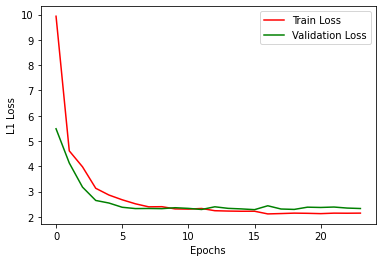

In [54]:
plt.plot(history["train_loss"], c = "r", label = "Train Loss")
plt.plot(history["val_loss"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.show()

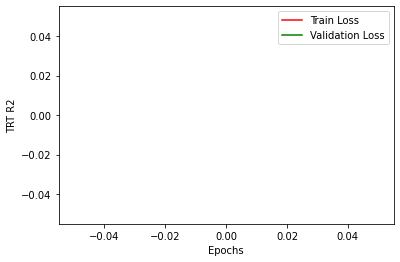

In [55]:
plt.plot(history["train_TRT"], c = "r", label = "Train Loss")
plt.plot(history["val_TRT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("TRT R2")
plt.show()

In [56]:
save_file_path = "/content/drive/MyDrive/CMCL Shared Task/single target training/nprop_RobertaToken_single_target.pth"
torch.save(model.state_dict(), save_file_path)